In [30]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [31]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [32]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [33]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

In [34]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [35]:
def train(model, optimizer, scheduler, n_epochs=5):
    val_losses_for_plot = []
    val_accs_for_plot = []
    epochs_for_plot = []
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.nll_loss(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.nll_loss(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
            val_losses_for_plot.append(np.mean(val_loss))
            val_accs_for_plot.append(np.mean(val_accuracy))
            epochs_for_plot.append(epoch)
            scheduler.step(np.mean(val_loss))
    return val_losses_for_plot, val_accs_for_plot, epochs_for_plot

In [36]:
train(model, optimizer,scheduler )

100%|██████████| 157/157 [00:02<00:00, 53.34it/s]


Epoch: 0, loss: 0.11949057877063751, accuracy: 0.9625


100%|██████████| 157/157 [00:03<00:00, 47.42it/s]


Epoch: 2, loss: 0.06045357137918472, accuracy: 0.981


100%|██████████| 157/157 [00:03<00:00, 48.08it/s]

Epoch: 4, loss: 0.059814319014549255, accuracy: 0.9809


([np.float32(0.11949058), np.float32(0.06045357), np.float32(0.05981432)],
 [np.float64(0.9625), np.float64(0.981), np.float64(0.9809)],
 [0, 2, 4])

100%|██████████| 157/157 [00:02<00:00, 52.73it/s]


Epoch: 0, loss: 0.044606827199459076, accuracy: 0.9855


100%|██████████| 157/157 [00:02<00:00, 54.24it/s]


Epoch: 2, loss: 0.04454183951020241, accuracy: 0.9863


100%|██████████| 157/157 [00:02<00:00, 53.79it/s]


Epoch: 4, loss: 0.042078565806150436, accuracy: 0.9868


100%|██████████| 157/157 [00:03<00:00, 41.45it/s]


Epoch: 6, loss: 0.044425539672374725, accuracy: 0.9862


100%|██████████| 157/157 [00:03<00:00, 49.94it/s]


Epoch: 8, loss: 0.04746706038713455, accuracy: 0.9867


100%|██████████| 938/938 [00:25<00:00, 37.48it/s]


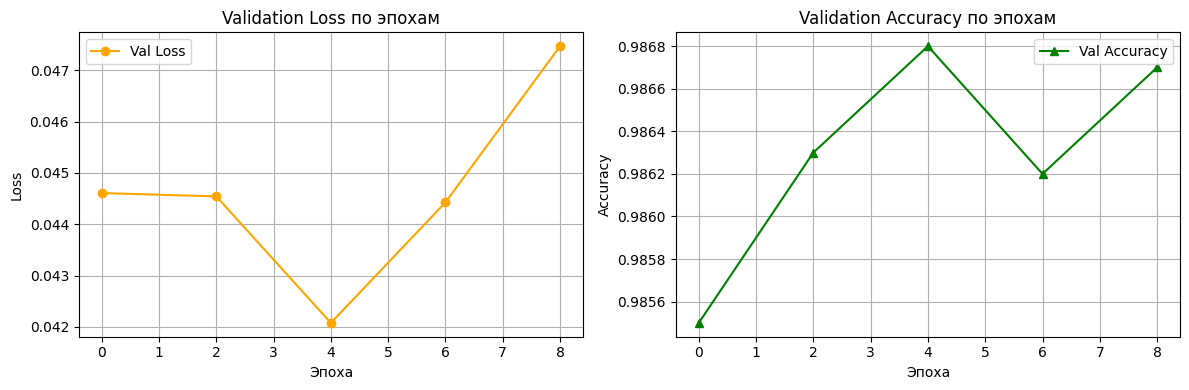

Лучшая точность: 0.9868
Минимальный loss: 0.042078565806150436


In [37]:
val_losses, val_accs, epochs = train(model, optimizer, scheduler, n_epochs=10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'o-', label='Val Loss', color='orange')
plt.title('Validation Loss по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, '^-', label='Val Accuracy', color='green')
plt.title('Validation Accuracy по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Лучшая точность: {max(val_accs)}")
print(f"Минимальный loss: {min(val_losses)}")

In [38]:
total = 0
for p in model.parameters():
    if p.requires_grad:
        total += p.numel()

print(f"Всего обучаемых параметров: {total}")

Всего обучаемых параметров: 47598


In [39]:
def create_model():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(6*6*10, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=1)
    )

In [40]:
configs = [
    {"name": "Adam_lr0.001_wd1e-4", "lr": 0.001, "weight_decay": 1e-4},
    {"name": "Adam_lr0.002_wd0",    "lr": 0.002, "weight_decay": 0},
    {"name": "Adam_lr0.0005_wd1e-5", "lr": 0.0005, "weight_decay": 1e-5}
]

In [42]:
results = []

for config in configs:
    print(f"Запускаем: {config['name']}")

    model = create_model()

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    val_losses, val_accs, epochs = train(model, optimizer, scheduler, n_epochs=5)

    best_acc = max(val_accs)
    min_loss = min(val_losses)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    results.append({
        "config": config['name'],
        "best_accuracy": best_acc,
        "min_loss": min_loss,
        "params": total_params,
        "val_accs": val_accs,
        "epochs": epochs
    })

Запускаем: Adam_lr0.001_wd1e-4


100%|██████████| 157/157 [00:02<00:00, 54.09it/s]


Epoch: 0, loss: 0.12214718759059906, accuracy: 0.9623


100%|██████████| 157/157 [00:03<00:00, 51.18it/s]


Epoch: 2, loss: 0.06752873212099075, accuracy: 0.9769


100%|██████████| 157/157 [00:03<00:00, 41.52it/s]


Epoch: 4, loss: 0.08401260524988174, accuracy: 0.9718
Запускаем: Adam_lr0.002_wd0


100%|██████████| 157/157 [00:03<00:00, 44.83it/s]


Epoch: 0, loss: 0.0781727135181427, accuracy: 0.974


100%|██████████| 157/157 [00:02<00:00, 55.09it/s]


Epoch: 2, loss: 0.05408730357885361, accuracy: 0.9808


100%|██████████| 157/157 [00:02<00:00, 54.34it/s]


Epoch: 4, loss: 0.051072996109724045, accuracy: 0.983
Запускаем: Adam_lr0.0005_wd1e-5


100%|██████████| 157/157 [00:02<00:00, 53.94it/s]


Epoch: 0, loss: 0.1288047581911087, accuracy: 0.9613


100%|██████████| 157/157 [00:02<00:00, 54.46it/s]


Epoch: 2, loss: 0.07273605465888977, accuracy: 0.976


100%|██████████| 157/157 [00:02<00:00, 54.75it/s]

Epoch: 4, loss: 0.05940689891576767, accuracy: 0.9799


In [43]:
for res in results:
    print(f"{res['config']:<25} , Accuracy: {res['best_accuracy']} ")

winner = max(results, key=lambda x: x['best_accuracy'])
print(f"{winner['config']} - {winner['best_accuracy']}")

Adam_lr0.001_wd1e-4       , Accuracy: 0.9769 
Adam_lr0.002_wd0          , Accuracy: 0.983 
Adam_lr0.0005_wd1e-5      , Accuracy: 0.9799 
Adam_lr0.002_wd0 - 0.983


In [44]:
if not results or best_acc > max([r['best_accuracy'] for r in results[:-1]] if len(results) > 1 else [0]):
  torch.save(model.state_dict(), 'best_model.pth')
